In [163]:
import numpy as np
import matplotlib.pyplot as plt
import dirichlet
from tqdm import tqdm

In [164]:
def plot_change_points(data, alarm_times, change_times):
    plt.plot(data, label='Data')
    for alarm in alarm_times:
        plt.axvline(x=alarm, color='red', linestyle='--', label='Alarm' if alarm == alarm_times[0] else "")
    for change in change_times:
        plt.axvline(x=change, color='green', linestyle='--', label='Change Point' if change == change_times[0] else "")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Detected Change Points")
    plt.legend()
    plt.show()

In [165]:
# gaussian sequence with 3 changes
change_mean_var = np.random.normal(0, 1, 100)

# change variance of points from 20 to 50 by multiplying by 3
change_mean_var[20:] *= np.sqrt(3)

# change mean of points from 50 onwards by adding 2
change_mean_var[50:] += 4

# change variance of points from 80 onwards by multiplying by 2
change_mean_var[80:] *= 2

true_changes_mean_var = [20, 50, 80]

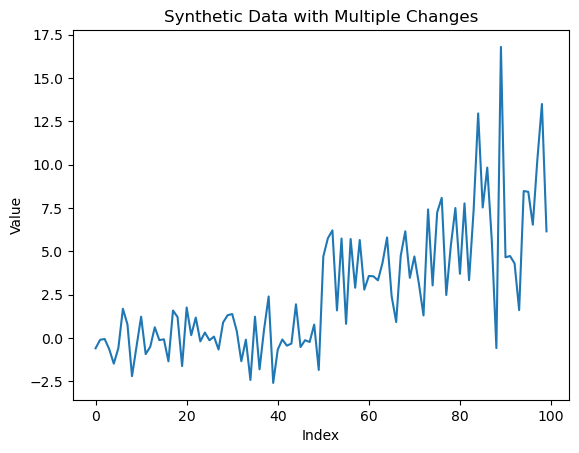

In [166]:
plt.plot(change_mean_var)
plt.title("Synthetic Data with Multiple Changes")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

In [167]:
change_covariance = np.random.multivariate_normal(
    np.zeros(3),
    np.eye(3),
    size=20
)

np.append(change_covariance, np.random.multivariate_normal(
    np.zeros(3),
    np.array([
        [1, 0.9, 0.9],
        [0.9, 1, 0.9],
        [0.9, 0.9, 1]
    ]),
    size=40
))

np.append(change_covariance, np.random.multivariate_normal(
    np.zeros(3),
    np.eye(3),
    size=40
))

true_changes_covariance = [20, 60]

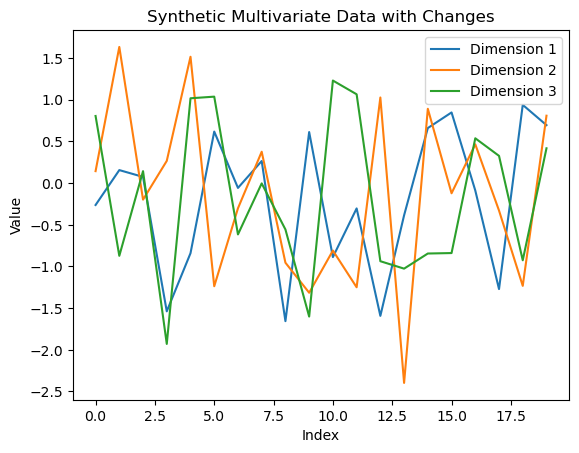

In [168]:
plt.plot(change_covariance[:, 0], label='Dimension 1')
plt.plot(change_covariance[:, 1], label='Dimension 2')
plt.plot(change_covariance[:, 2], label='Dimension 3')
plt.legend()
plt.title("Synthetic Multivariate Data with Changes")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

In [169]:
# sequence with change in tail behavior
change_tail = np.random.multivariate_normal(
    np.zeros(2),
    np.eye(2),
    size=60
)

# next 40 samples are drawn from a bivariate t distribution with 2 degrees of freedom
change_tail = np.concatenate([change_tail, np.random.standard_t(2, size=(40, 2))])

true_changes_tail = [60]

In [170]:
# sequence with change in Poisson intensity parameter
change_poisson = np.random.poisson(lam=3, size=40)

# next 40 samples are drawn from a Poisson distribution with a higher intensity
change_poisson = np.concatenate([change_poisson, np.random.poisson(lam=6, size=40)])

# change back to the original intensity
change_poisson = np.concatenate([change_poisson, np.random.poisson(lam=3, size=20)])

true_changes_poisson = [40, 80]

In [171]:
# sparse change in mean with overlapping segments
change_sparse = np.random.multivariate_normal(
    np.zeros(50),
    np.eye(50),
    size=100
)

# change mean of points from 20 to 22 by adding 5
mean_change = np.zeros(50)
mean_change[20:22] = 5
change_sparse[50:] += mean_change

# change mean of points from 40 to 42 by adding 10
mean_change = np.zeros(50)
mean_change[40:42] = 10
change_sparse[80] += mean_change

true_changes_sparse = [20, 22, 40, 42]

In [172]:
def multiple_change_detection(data, find_single_cp, min_window_size=10, batch_size=2, kernel=None, threshold=None):
    """
    Detect multiple changes in the data using the find_single_cp function.
    Append new points if no changes are detected in the current window.
    """
    changes = []
    window = data[:min_window_size]
    window_end = min_window_size
    window_start = 0
    while window_end < len(data):
        if kernel is not None:
            cp, _ = find_single_cp(window, kernel, threshold)
        else:
            cp, _ = find_single_cp(window, threshold=threshold)
        if cp is not None:
            changes.append(window_start + cp)
            window_end += cp + min_window_size - 1
            if window_end >= len(data):
                break
            window = data[cp:window_end]
            window_start = cp
        else:
            window = np.concatenate((window, data[window_end:window_end + batch_size]))
            window_end += batch_size
    return changes

In [173]:
def filtered_derivative(sequence, conv_kernel=None, threshold=None):
    """
    Perform change point detection on a sequence using a filtered derivative approach.
    """
    if conv_kernel is None:
        conv_kernel = np.ones(5) / 5
    filtered = np.convolve(sequence, conv_kernel, mode='valid')
    # return first index where the filtered derivative exceeds a threshold
    if threshold is None:
        threshold = np.std(filtered) * 2
    change_points = np.where(np.abs(np.diff(filtered)) > threshold)[0]
    return change_points[0] if change_points.size > 0 else None, None

In [174]:
changes_default_kernel = multiple_change_detection(change_mean_var, filtered_derivative, min_window_size=10, batch_size=5)
changes_default_kernel

[np.int64(6), np.int64(29)]

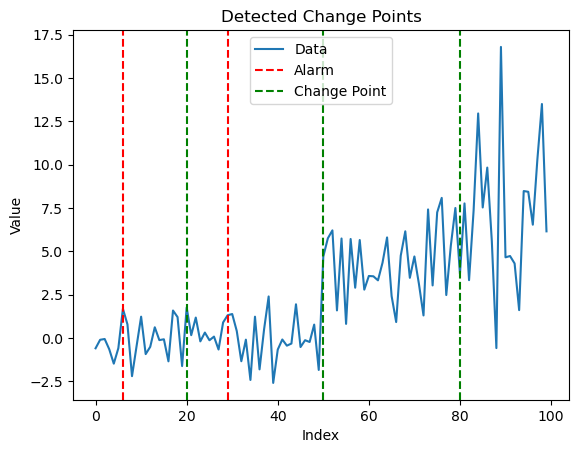

In [175]:
plot_change_points(change_mean_var, changes_default_kernel, true_changes_mean_var)

In [176]:
# create a custom kernel for Gaussian distribution
def gaussian_kernel(size, sigma=1):
    """Create a Gaussian kernel."""
    x = np.linspace(-size // 2, size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    return kernel / np.sum(kernel)

In [177]:
def shewhart_control_chart(data, control_limit=3, threshold=None):
    """
    Apply Shewhart control chart to detect anomalies in the data.
    """
    mean = np.mean(data)
    std = np.std(data)
    if threshold is None:
        threshold = std * control_limit
    upper_control_limit = mean + threshold
    lower_control_limit = mean - threshold

    for i, value in enumerate(data):
        if value > upper_control_limit or value < lower_control_limit:
            return i, None  # Return the index of the anomaly

    return len(data), None

In [178]:
changes_gaussian_shewhart = multiple_change_detection(change_mean_var, shewhart_control_chart)
changes_poisson_shewhart = multiple_change_detection(change_poisson, shewhart_control_chart)

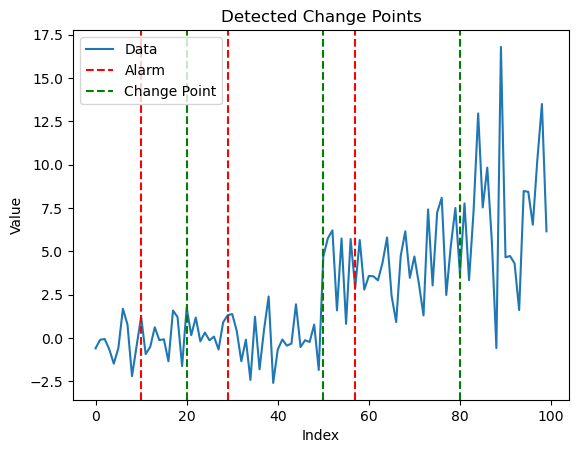

In [179]:
plot_change_points(change_mean_var, changes_gaussian_shewhart, true_changes_mean_var)

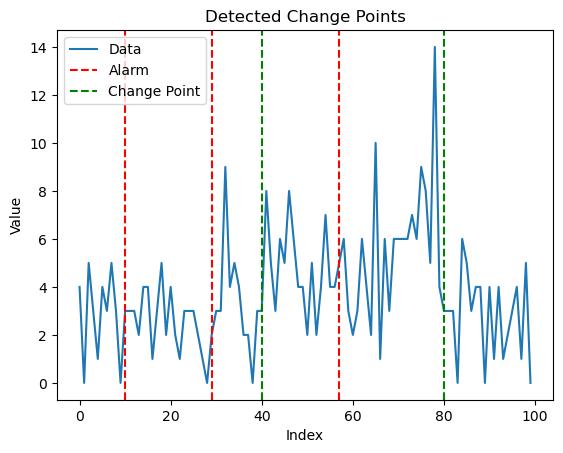

In [180]:
plot_change_points(change_poisson, changes_poisson_shewhart, true_changes_poisson)

In [181]:
def finite_moving_average_control_chart(data, window_size=5, filter=None, threshold=1):
    """
    Apply a finite moving average control chart to the data.
    """
    if threshold is None:
        threshold = 1
    if filter is None:
        # all previous values are equally weighted
        filter = np.ones(window_size) / window_size

    for i in tqdm(range(len(filter), len(data))):
        window = data[i - window_size:i]
        fma = np.convolve(window, filter, mode='valid')[0]

        if fma > threshold:
            return i, None  # Return the index of the anomaly

    return None, None  # No anomaly detected

In [182]:
changes_gaussian_fma = multiple_change_detection(change_mean_var, finite_moving_average_control_chart)
changes_poisson_fma = multiple_change_detection(change_poisson, finite_moving_average_control_chart)

  0%|          | 0/84 [00:00<?, ?it/s]


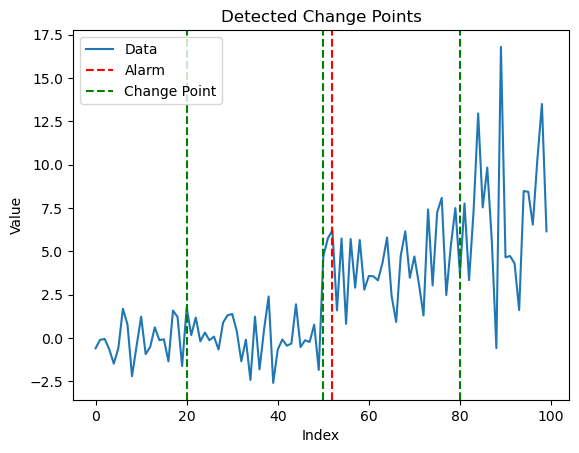

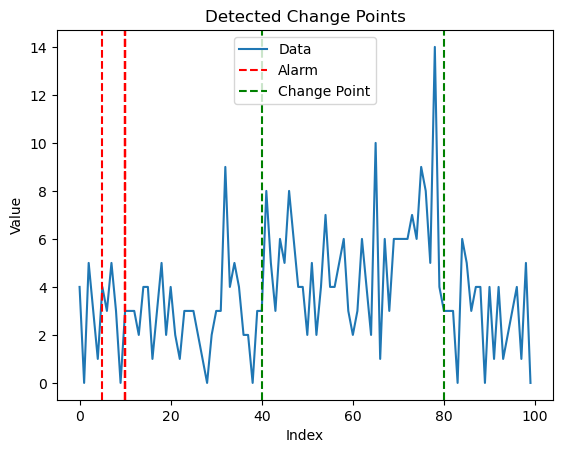

In [183]:
plot_change_points(change_mean_var, changes_gaussian_fma, true_changes_mean_var)
plot_change_points(change_poisson, changes_poisson_fma, true_changes_poisson)

In [184]:
def geometric_moving_average_control_chart(data, threshold=1, min_window_size=5, discount=0.1):
    """
    Apply a geometric moving average control chart to the data.
    """
    if threshold is None:
        threshold = 1
    if len(data) < min_window_size:
        return None, None  # Not enough data

    gma = 0
    for i in range(min_window_size, len(data)):
        gma = (1-discount) * gma + discount * data[i]
        if gma > threshold:
            return i, None
    return None, None

In [185]:
changes_gaussian_gma = multiple_change_detection(change_mean_var, geometric_moving_average_control_chart, min_window_size=10, batch_size=5, threshold=1)
changes_poisson_gma = multiple_change_detection(change_poisson, geometric_moving_average_control_chart, min_window_size=10, batch_size=5, threshold=1)

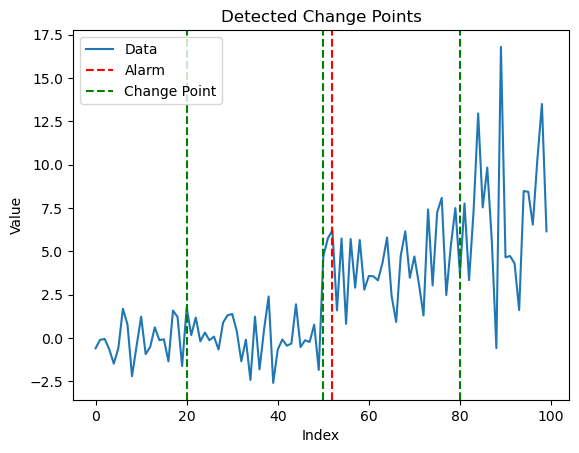

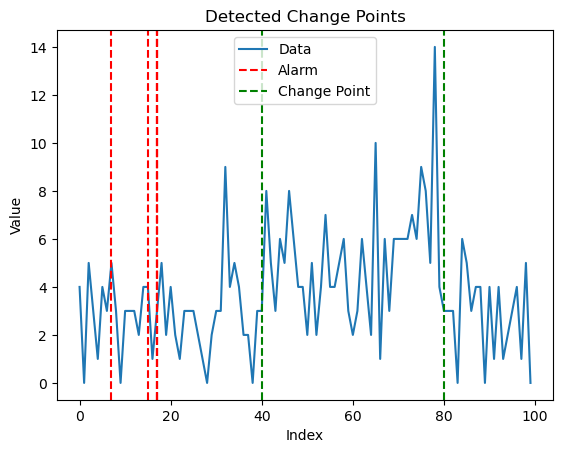

In [186]:
plot_change_points(change_mean_var, changes_gaussian_gma, true_changes_mean_var)
plot_change_points(change_poisson, changes_poisson_gma, true_changes_poisson)

In [187]:
def cusum(data, threshold = 5, min_window = 3):
    """
    Cumulative Sum Control Chart for change point detection.
    """
    if threshold is None:
        threshold = 0
    g = 0
    for i in range(len(data)):
        g += data[i]
        g = max(g, 0)
        if i >= min_window:
            # Check for change point
            if g > threshold:
                return i, None  # Return the index of the change point
    return len(data), None  # No change point detected

In [188]:
changes_gaussian_cusum = multiple_change_detection(change_mean_var, cusum, min_window_size=10, batch_size=5, threshold=10)
changes_poisson_cusum = multiple_change_detection(change_poisson, cusum, min_window_size=10, batch_size=5, threshold=10)

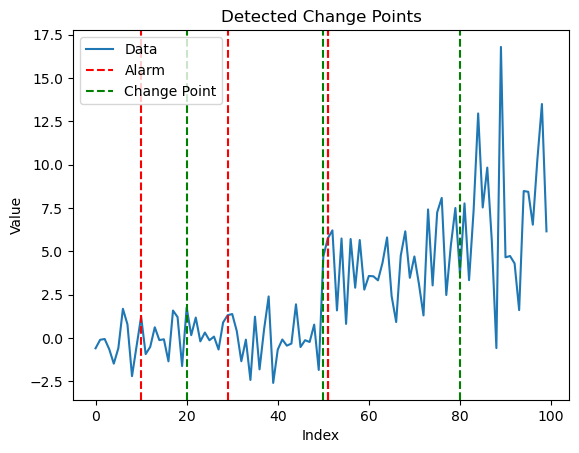

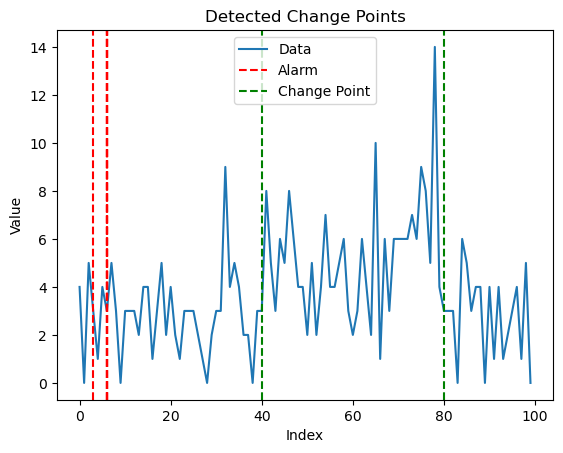

In [189]:
plot_change_points(change_mean_var, changes_gaussian_cusum, true_changes_mean_var)
plot_change_points(change_poisson, changes_poisson_cusum, true_changes_poisson)